## Set up

In [4]:
import numpy as np
import tensorflow as tf
import keras as tfk
import numpy as np
import seaborn as sns
from keras import layers as tfkl
from sklearn.manifold import TSNE

from pathlib import Path

sns.set_theme()

In [5]:
DATA_PATH = Path().absolute().parent / "data" / "training_set.npz"
PROFILING_DIR = Path().absolute().parent / "data" / "profiling"
EMBEDDINGS_DIR = Path().absolute().parent / "data" / "embeddings"
DATA_PATH

PosixPath('/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-1/data/training_set.npz')

In [6]:
BATCH_SIZE = 32

## Compute embeddings

### Load

In [4]:
with np.load(DATA_PATH) as data:
    images = data["images"]
    labels = data["labels"]

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 1)


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [6]:
train_images = train_dataset.map(lambda x, _: x, num_parallel_calls=tf.data.AUTOTUNE)
train_images

<_ParallelMapDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None)>

### Build model

In [ ]:
inputs = tfkl.Input((96, 96, 3))

x = tfkl.Resizing(224, 224)(inputs)
feature_extractor = tfk.applications.EfficientNetV2B3(
    include_top=False,
    pooling="max",
)
outputs = feature_extractor(x)

model = tfk.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

### Get model predictions

In [8]:
embeddings = model.predict(train_images.prefetch(tf.data.AUTOTUNE))
embeddings

430/430 ━━━━━━━━━━━━━━━━━━━━ 97s 224ms/step


array([[ 7.4408865e-01,  5.1452178e-01, -1.3243177e-03, ...,
        -8.7809684e-03,  5.6505930e-02,  3.8756807e+00],
       [ 2.0958393e+00,  6.7020759e-02, -2.1551470e-03, ...,
         1.5144008e+00,  1.9123180e+00,  3.6413898e+00],
       [ 2.8783131e+00,  3.9427049e+00, -8.2931994e-03, ...,
         4.0548329e+00,  1.7053944e+00,  4.4268384e+00],
       ...,
       [ 7.5387143e-02,  4.0423999e+00, -2.3322173e-04, ...,
         5.0116873e+00,  4.6268053e+00,  2.1751354e+00],
       [ 7.5387143e-02,  4.0423999e+00, -2.3322173e-04, ...,
         5.0116873e+00,  4.6268053e+00,  2.1751354e+00],
       [ 7.5387143e-02,  4.0423999e+00, -2.3322173e-04, ...,
         5.0116873e+00,  4.6268053e+00,  2.1751354e+00]], dtype=float32)

In [9]:
embeddings.shape

(13759, 1280)

### Save embeddings

In [22]:
np.save(EMBEDDINGS_DIR  / feature_extractor.name, embeddings)

## Load embeddings

In [7]:
embeddings = np.load(EMBEDDINGS_DIR / "efficientnetb0.npy")
embeddings.shape

(13759, 1280)

In [8]:
with np.load(DATA_PATH) as data:
    labels = np.ravel(data["labels"])
labels.shape

(13759,)

## Analyse embeddings

In [9]:
tsne = TSNE()
embeddings_tsne: np.ndarray = tsne.fit_transform(embeddings)
embeddings_tsne.shape

(13759, 2)

<Axes: >

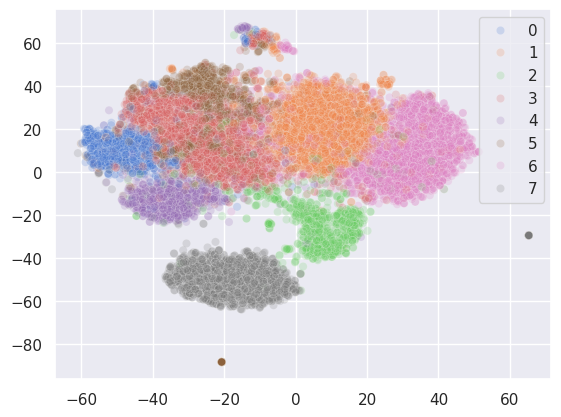

In [10]:
sns.scatterplot(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    hue=np.ravel(labels),
    palette="muted",
    alpha=0.2,
)

In [11]:
junk_indices = np.load(PROFILING_DIR / "junk_indices.npy")
junk_support = np.zeros(embeddings.shape[0])
junk_support[junk_indices] = 1
junk_support

array([0., 0., 0., ..., 1., 1., 1.])

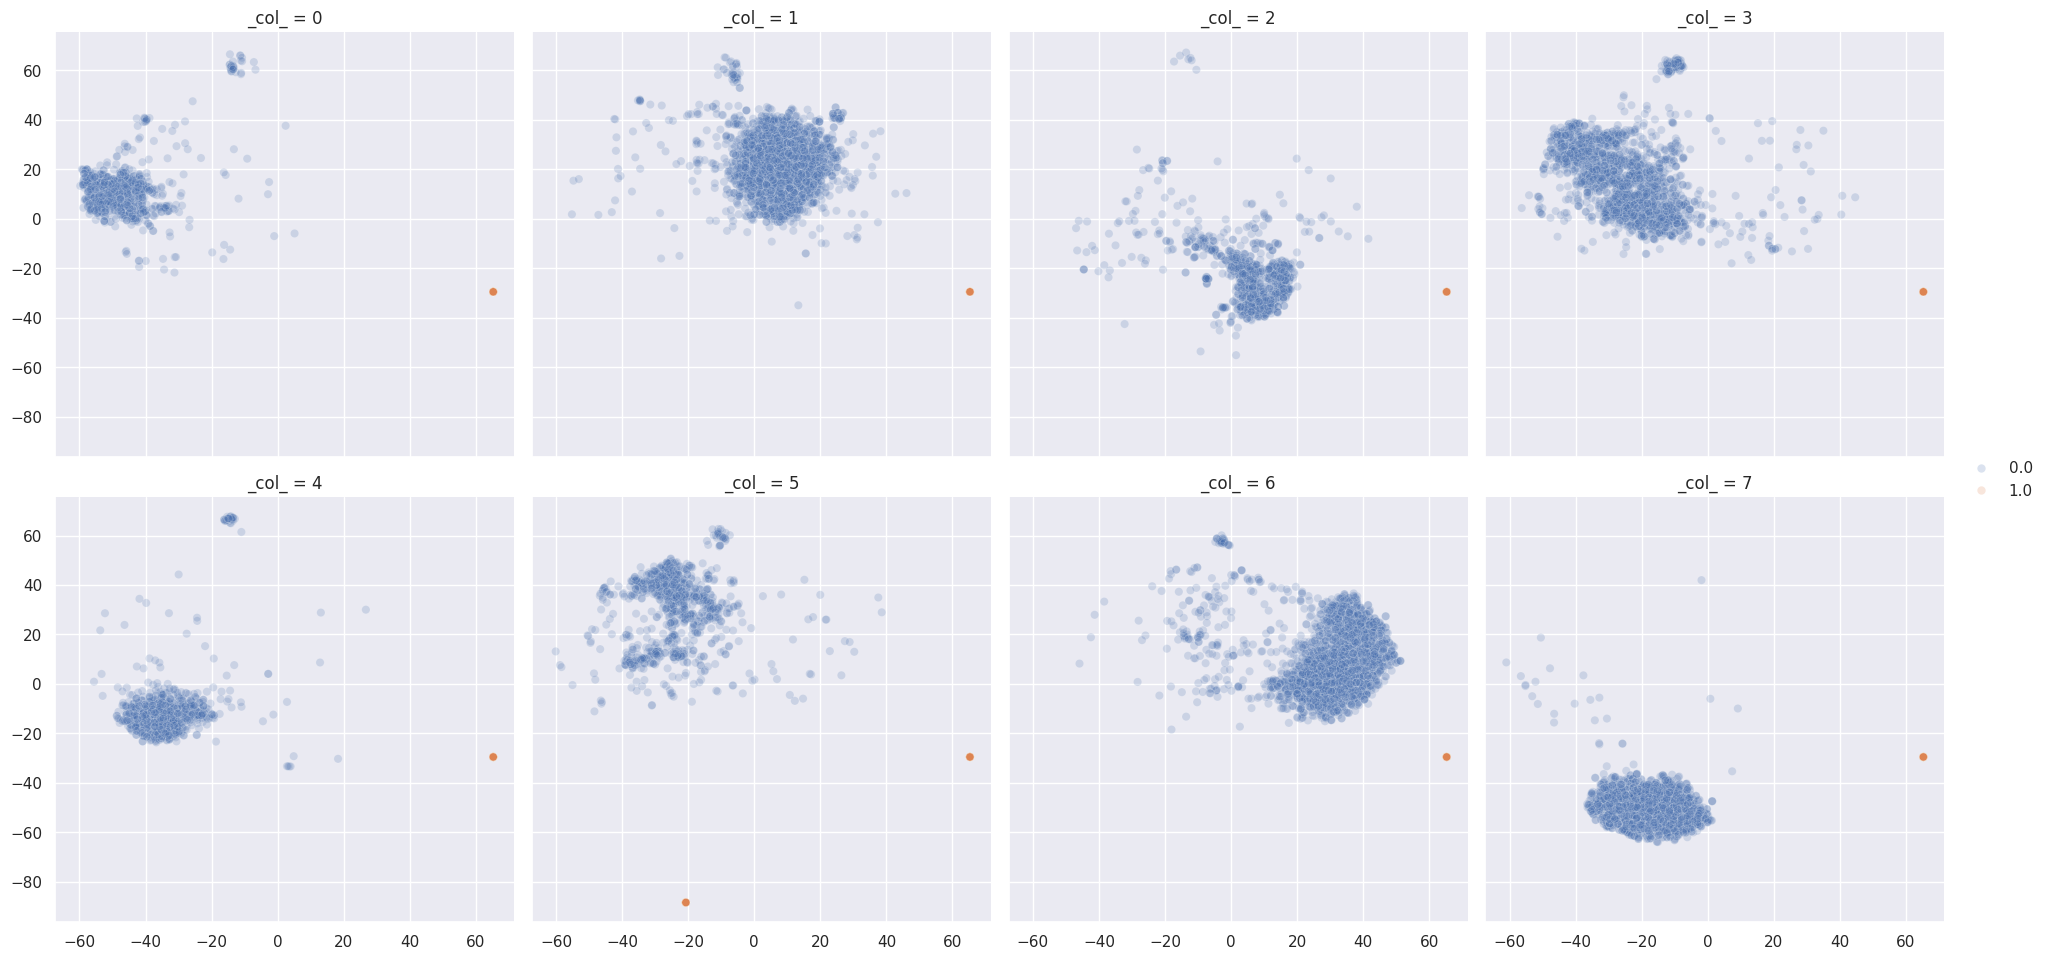

In [12]:
sns.relplot(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    col=np.ravel(labels),
    col_wrap=4,
    hue=junk_support,
    alpha=0.2,
)